In [1]:
import numpy as np
from numpy import exp, sqrt, abs
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 14

In [2]:
# Defining Restricted Boltzmann Machine class
class RBM:
    # Initializing the weight matrix, visible bias and hidden bias
    def __init__(self, input_size, hidden_size):
        sigma = np.sqrt(4. / float(L + M))
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.W = np.random.randn(input_size, hidden_size)*sigma #(20,6)
        self.a = np.random.randn(input_size, 1)*sigma #(20,1)
        self.b = np.zeros(hidden_size) #(1,6)
        #return self.W, self.a, self.b

    # taking into account energy gap DE=2 for "spin" variables (-1,1)
    def sigmoid(self, x, DE=2):
        return 1 / (1 + np.exp(-x*DE))

    def positive_phase(self, v_0):
               
        h_0_prob = self.sigmoid(np.dot(v_0, self.W) + self.b)
        h_0 = np.random.binomial(size=h_0_prob.shape, n=1, p=h_0_prob)
        #print(h_0_prob.shape)
        return h_0_prob, h_0

    def negative_phase(self, h_0):
        v_f_prob = self.sigmoid(np.dot(h_0, self.W.T) + self.a.T)
        v_f = np.random.binomial(size=v_f_prob.shape, n=1, p=v_f_prob)
        return v_f_prob, v_f

    def fantasy_particles(self, v_f): # another positive fase but to generate fantasy hidden variables
        h_f_prob = self.sigmoid(np.dot(v_f, self.W) + self.b)
        h_f = np.random.binomial(size=h_f_prob.shape, n=1, p=h_f_prob)
        return h_f_prob, h_f
    
    '''
    def extract_energy_level(probabilities): # this method returns the E_n corresponding to the prob after 
        cdf = np.cumsum(probabilities)           # after drawing a random n° (prob) from 0 to 1
        r = np.random.uniform()
        for i in range(len(cdf)):
            if r < cdf[i]:
                return i
    '''
    # Energy 
    def energy_part(self, v_0):
        energy_bin = []
        E_n = [] 
        for i in range(4):
            energy_vec = np.zeros((1, 4))
            energy_vec[:, i] = 1
            energy_bin.append(energy_vec) 
        for i in range (4):
            energy_p = np.dot((np.dot(v_0, self.W) + self.b).T, energy_bin[i])
            E_n.append(energy_p)
        return E_n, energy_bin
        return energy_bin
    
    # Temperature: if the temp is too low, the energy of the 1st level can be too low, and the prob
    # would be the dom factor and the "extraction" from the cumulative can be misleading 
    def prob_part(self, E_n, ampl = 0.05):
        p_n = []
        Z = np.sum(E_n)
        for i in range(4):
            pe_i = np.exp(-E_n[i]*ampl) / Z
            p_n.append(pe_i)
        return p_n
    
    # One-Hot Encoding
    def one_hot_encoding(self, v_0): #, energy_bin, p_n):
        E_n, energy_bin = self.energy_part(v_0)
        p_n = self.prob_part(E_n)
        
        cdf = np.cumsum(p_n)           # after drawing a random n° (prob) from 0 to 1
        r = np.random.uniform()
        v_f = np.zeros((N, L))
        for s in range (N):
            
            for c in range(5):
                for i in range(4):
                    if r < cdf[i]:
                        v_f[s, 4*c:4*c+4] = energy_bin[i]
                #energy_vec = np.zeros((v_f.shape[0], 4)) # create a one-hot encoding vector for the energy level 
                #energy_vec[:, energy_level] = 1 # set the appropriate element in the vector to 1 using the energy level as the index
                        #v_f = np.concatenate((v_f, self.E_n[i]), axis=1) # concatenate energy_vector with the visible units

                        #h_f_prob = self.sigmoid(np.dot(v_f, self.W) + self.b.T) # hidden variables probability
                        #h_f = np.random.binomial(size=h_f_prob.shape, n=1, p=h_f_prob) # sample hidden units
                        #return h_f_prob, f_k
        return v_f

    def contrastive_divergence(self, v_0, k=1): # k is the CD-n n
        h_0_prob, h_0 = self.positive_phase(v_0)
        #h_0_prob = h_0_prob.reshape(1,6)
        #h_0_prob = np.squeeze(h_0_prob)
        
        #print(h_0_prob.shape)
        
        for i in range(k):
            v_f = self.one_hot_encoding(v_0)
            #v_f_prob, v_f = self.negative_phase(h_0)
            h_f_prob, h_f = self.positive_phase(v_f)#, energy_bin, p_n)
            
            h_0 = h_f
        #print(v_f.shape)   
        #v_0 = np.expand_dims(v_0, axis=0)
        #v_f = np.expand_dims(v_f, axis=0)
        #h_0_prob = np.expand_dims(h_0_prob, axis=0)
        #h_f_prob = np.expand_dims(h_f_prob, axis=0)
        dW = np.dot(v_0.T, h_0_prob) - np.dot(v_f.T, h_f_prob)
        da = np.sum(v_0 - v_f, axis=0, keepdims=True).T
        db = np.sum(h_0_prob - h_f_prob, axis=0, keepdims=True).T

        return dW, da, db

    def train(self, X, learning_rate, epochs, mini_batch, N, k=1):
        #print(X[2].shape)
        l_rate_m = learning_rate / mini_batch
        for epoch in range(epochs):
            dW = np.zeros_like(self.W)
            da = np.zeros_like(self.a)
            db = np.zeros_like(self.b)
            
            for i in range(N):
                x = v_0[i][:]
                x = x.reshape(1,-1)
                #print(x.ndim)
                
                dW_i, da_i, db_i = self.contrastive_divergence(x, k=k)
                dW = dW + dW_i
                da = da + da_i
                db = db + db_i

            self.W = self.W + l_rate_m * dW / X.shape[0]
            self.a = self.a + l_rate_m * da / X.shape[0]
            self.b = self.b + l_rate_m * db / X.shape[0]
            
            learning_rate = learning_rate / (0.01 * learning_rate + 1)
            return dW, da, db, self.W, self.a, self.b
            
            '''
            if epochs%10==9:
                plotgraph(epochs+1)
                print('l_rate = ', learning_rate)
            '''    

    def sample(self, n):
        x = np.random.randn(n, self.input_size)
        h = self.sigmoid(np.dot(x, self.W) + self.b.T)
        return self.sigmoid(np.dot(h, self.W.T) + self.a.T)

    # RMSProb -> explode much slowly
    

In [3]:
CASE=1
if CASE==1: fname = "DATA_b/x_RBM_q0.1.dat"
if CASE==2: fname = "DATA_c/x_RBM_q0.2.dat"

# loading data: each row is a list of visible units
# NOTE: data "x" here is named "v" for "visible"
v = np.loadtxt(fname, delimiter=" ", dtype=int)

# store in v0, because later we will shuffle v
v_0 = np.copy(v)

# to start, take a small subsample
#v = v[1:11]
N = len(v)
L = len(v[1])

SPINS = True
#SPINS = False

if SPINS:
    # sigmoid takes into account energy difference =2
    GAP=2
    # convert 0,1 -> -1,1
    v = 2*v - 1
    vmin=-1
else:
    GAP=1
    vmin=0

print(f'each of N={N} data has L={L} digits')

for i in range(min(12, N)):
    if SPINS: print(v_0[i], "\n->", v[i])
    else: print(v[i])
print('...')

each of N=10000 data has L=20 digits
[0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0] 
-> [-1 -1  1 -1  1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1  1 -1]
[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1] 
-> [-1 -1  1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1  1]
[0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1] 
-> [-1 -1  1 -1 -1  1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1  1]
[0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0] 
-> [-1  1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1  1 -1  1 -1 -1 -1]
[0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0] 
-> [-1 -1  1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1]
[0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0] 
-> [-1 -1 -1  1 -1  1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1  1 -1]
[0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0] 
-> [-1 -1  1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1  1 -1 -1]
[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1] 
-> [-1 -1  1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1  1]
[1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0] 
-> [ 1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1  1 -1 -1  1 -

In [4]:
print(v_0[2,:].shape)

(20,)


In [5]:
# RBM, nr of hidden variables
if CASE==1: M = 6
if CASE==2: M = 2

'''
# range of each initial weight
sigma = np.sqrt(4. / float(L + M)) 

# random seed for reproducibility
np.random.seed(12345)

# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
w = sigma * np.random.randn(L, M)
a = sigma * np.random.randn(L) #bias
b = np.zeros(M)
'''
rbm = RBM(input_size=L, hidden_size=6)


#print("w=", self.W); print("a=", self.a); print("b=", self.b)

#w0, a0, b0 = np.copy(w), np.copy(a), np.copy(b)

In [6]:
print("w=", rbm.W); print("a=", rbm.a); print("b=", rbm.b)

w= [[-0.43498673  0.19069273 -0.0518617  -0.04823746 -0.15332129 -0.14289202]
 [-0.41920394  0.6434865  -0.03063837  0.68280601 -0.00522823 -0.37468027]
 [ 0.1335251  -0.41725961 -0.23109189  0.21184889  0.39565099 -0.24299058]
 [-0.73431901 -0.10206604  0.24391994 -0.09715821 -0.01718036  0.5453144 ]
 [ 0.11921921  0.35333535  0.01442189 -1.05201859 -0.2088648   0.14787649]
 [-0.03665762 -0.24365986 -0.73033677 -0.17036061 -0.53779889  0.48361786]
 [-0.216919    0.82438136  0.02456437  0.37752555 -0.96404372  0.84242422]
 [-0.40093842  0.05785305 -0.13171273  0.10628599 -0.23946276 -0.14190811]
 [-0.24416034 -0.38562759  1.18245039 -0.30860841  0.12075848 -0.26800695]
 [-0.26748498  0.71534229  0.2002959   0.34862087 -0.38960143  0.02202115]
 [-0.03086713 -0.15948717  0.67412348 -0.24907543 -0.37262998 -0.17970686]
 [-0.0716164   0.71418219 -0.72781695 -0.11875864  0.9292742   0.17190253]
 [ 0.0754353   0.05341706 -0.14665425 -0.41414444 -0.30325642  0.06595187]
 [-0.31061331 -0.88503

In [7]:
print(rbm.W.shape, rbm.a.shape, rbm.b.shape)
ciao = np.dot(rbm.a.T, rbm.W)
print(ciao[0][1])

(20, 6) (20, 1) (6,)
-0.3548139992770468


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1]


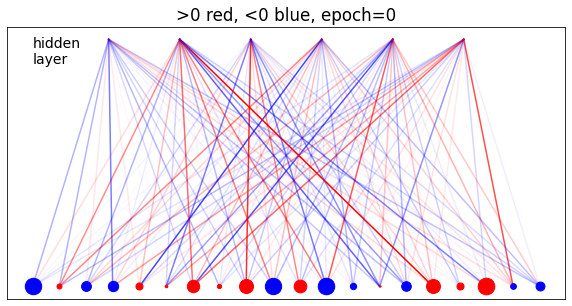

In [8]:
def create_coord(pp, x0, f=1.0):
    x = [x0] * pp
    print(x)
    y = list(range(pp))
    for i in range(pp):
        y[i] = f*(y[i]/(pp-1.) - 0.5)
    return (x,y)
(x1, y1) = create_coord(L, 0)
(x2, y2) = create_coord(M, 1, f=0.7)

def mycolor(val):
    if val>0: return 'red'
    elif val<0: return 'blue'
    else: return 'black'

def plotgraph_vert(epoch=0):
    A = 2./rbm.W.max()
    for i in range(L):
        for j in range(6):
            ex, ey, col = (x1[i], x2[j]), (y1[i], y2[j]), mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*abs(w[i][j]))
    # Scatter plot on top of lines
    
    A=300./(rbm.a.max()+rbm.b.max())
    
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*abs(rbm.a[i]), zorder=2, c=mycolor(rbm.a[i]))

    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*abs(rbm.b[j]), zorder=2, c=mycolor(rbm.b[j]), marker="s")
    plt.figaspect(1)
    plt.title(f'>0 red, <0 blue, epoch={epoch}')
    plt.show()
    
def plotgraph(epoch=0):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.tick_params(left=False, bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(rbm.W.max(), -rbm.W.min())
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i], y2[j]), (x1[i], x2[j]), mycolor(rbm.W[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(rbm.W[i][j]))
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    A=500.
    for i in range(L):
        ax.scatter(y1[i], x1[i], s=A*abs(rbm.a[i]), zorder=2, c=mycolor(rbm.a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300, A*abs(rbm.b[j])), zorder=2, c=mycolor(rbm.b[j]), marker="s")
    ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    ax.text(-0.5, 0.9, "hidden\nlayer")
    plt.show()
                  
plotgraph()

In [ ]:
# random seed for reproducibility
np.random.seed(12345)

# learning rate
#l_rate_i = 1.0
#l_rate = l_rate_i / (0.01 * l_rate + 1)
#if epoch%10==9:
    #plotgraph(epoch+1)
    #print('l_rate = ', l_rate)

# minibatch
#mini, m = 150, 0

# train model
print('===================================================')

rbm.train(X=v_0, learning_rate=1.0, epochs=1, mini_batch=100, N=N)
plotgraph(0)